# Assignment 1 - Option B - Jacob Hargreaves - 2401649

### Monte Carlo simulations for modelling a particle physics experiment

This notebook simulates a beam of partickes travelling along the $z$ axis with a mean veloicty of $2000ms^{-1}$. Each decays into a daughter particle after a mean lifetime of $2.5ms$ which is then propelled out of the decay point isotropically. Four tracking stations are placed at $ z = 30, 35, 40, 45m$ and are square surfaces of side length $5m$ which detect any daughter particles incident upon them with a resolution of $\pm0.01m$. This simulation displays the positions of all particles incident upon each of the four stations and analyses the breakdown of how many particles connect with each station. 

In [104]:
# importing the relevant libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.integrate import quad
from IPython.display import Markdown


In [105]:
# the base parameters are defined as stated in the assignment brief
N = 10**6
mean_v = 2000
std_v = 50
Lambda = 0.0025
a = b = 2.5

These first two functions create and decay a single particle according to the parameters given. $z$-velocity is drawn from a normal distributionn while decay time is drawn from an exponential distribution. 

In [106]:
# generate a beam of particles with velocities selected from a normal distribution with their initial positions equal to zero, working in 3D
# then generate decay times for particles based on an exponential distribution
# finally, calculates their decay positions based on their velocities and the dcay time

def generate_and_decay(N, mean_v, std_v, Lambda):

    velocities = np.random.normal(mean_v, std_v, N)

    decay_time = np.random.exponential(Lambda, N)
    decay_z_pos = decay_time * velocities

    return decay_z_pos


As each particle has it's $z$-velocity drawn from a normal distribution of mean $\mu_v = 20000ms^{-1}$ and it's decay time from an exponential distribution of mean $\tau = 2.5ms$, the mean distance travelled by a particle before decaying should be $5m$. 

The resulting distribution of the particles can be given by the probability density function of:

$$ f(z) = \int_0^\infty \frac{1}{b} N (\mu, \sigma^2) Exp(\lambda) db$$

which is equivalent to:

$$ f(z) = \frac{\lambda}{\sqrt{2 \pi} \sigma} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db$$

The next cell tests the two functions above to check the distribution of the decay distances of the particles and check the mean decay distance. 

The probability distribution function is multiplied by $10^6$ and plotted alongside the measured distribution to ensure the code is running correctly. 



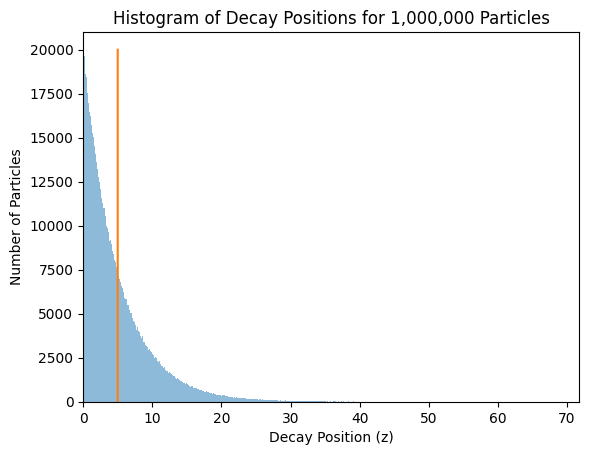

Mean Decay Distance: 5.003m

In [107]:
decay_positions = []

decay_z_pos = generate_and_decay(N, mean_v, std_v, Lambda)

plt.hist(decay_z_pos, bins=np.arange(0, max(decay_z_pos), 0.1) - 0.5, alpha=0.5)
plt.plot(np.ones(20000)*5, np.arange(0,20000))
plt.xlabel('Decay Position (z)')
plt.ylabel('Number of Particles')
plt.title('Histogram of Decay Positions for 1,000,000 Particles')
plt.xlim(0, max(decay_z_pos))
plt.show()

mean_decay_distance = np.mean(decay_z_pos)

Markdown(f"Mean Decay Distance: {mean_decay_distance:.3f}m")

# do proper statistical test here

         

The results above show the code runs as intended. 

These next cells create the initial direction of the daughter particle and calculate it's trajectory in the $x$ and $y$ axes. 

The initial direction of the daughter particle should be created isotropically as we are able to assume the momentum of the daughter particle is signaificantly higher than that of the parent particle. 

In [108]:
# function to select the daughter particle direction based on it being isotropic

def daughter_initial_direction(N):
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    phi = 2 * np.pi * np.random.uniform(0, 1, N)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    norm = np.sqrt(x**2 + y**2 + z**2)
    x /= norm
    y /= norm
    z /= norm
    return x, y, z


The code in the cell below tests the output of the daughter_initial_direction function. Ensuring this is correct is crucial to the rest of the simulation as any dicrepency in the distribution will throw off further results. 

In [109]:


# # Extract theta (angle from z-axis)
# cos_theta = directions[:, 2]  # z-component = cos(θ)

# # Kolmogorov-Smirnov test for uniformity
# ks_stat, p_value = stats.kstest(cos_theta, 'uniform', args=(-1, 2))  # uniform on [-1, 1]

# print(f"KS statistic: {ks_stat:.4f}")
# print(f"p-value: {p_value:.4f}")

# if p_value > 0.05:
#     print("✓ cos(θ) is uniformly distributed (isotropic)")
# else:
#     print("✗ cos(θ) is NOT uniformly distributed")

# # Visual check
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.hist(cos_theta, bins=50, density=True, alpha=0.7, edgecolor='black')
# plt.axhline(y=0.5, color='r', linestyle='--', label='Expected (uniform)')
# plt.xlabel('cos(θ)')
# plt.ylabel('Density')
# plt.title('Distribution of cos(θ)')
# plt.legend()

# plt.subplot(1, 3, 2)
# phi = np.arctan2(directions[:, 1], directions[:, 0])
# plt.hist(phi, bins=50, density=True, alpha=0.7, edgecolor='black')
# plt.axhline(y=1/(2*np.pi), color='r', linestyle='--', label='Expected')
# plt.xlabel('φ (radians)')
# plt.ylabel('Density')
# plt.title('Distribution of φ')
# plt.legend()

# plt.tight_layout()
# plt.show()


# # smooth this out a bit - too long and clunky
# # statistical test again


In [110]:
# # function to track the daughter particle at each tracking station

def daughter_position_eqn(detector_positions, decay_z_pos, x, y, z):
    first_detector = min(detector_positions)
    valid_mask = (decay_z_pos < first_detector) & (z > 0)

    m_x = np.where(valid_mask, x / z, 0)
    m_y = np.where(valid_mask, y / z, 0)

    c_x = np.where(valid_mask, -m_x * decay_z_pos, 0)
    c_y = np.where(valid_mask, -m_y * decay_z_pos, 0)

    return m_x, m_y, c_x, c_y, valid_mask


# find out what the fuck a mask is and what broadcasting is!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [111]:
def detect_hits(detector_positions, m_x, m_y, c_x, c_y, a, valid_mask):
    detector_z = np.asarray(detector_positions)
    num_events = len(m_x)
    num_det = len(detector_z)

    # Compute true positions
    x_true = m_x[:, None] * detector_z + c_x[:, None]
    y_true = m_y[:, None] * detector_z + c_y[:, None]

    # In bounds mask
    in_bounds = ((-a < x_true) & (x_true < a) & (-a < y_true) & (y_true < a) & valid_mask[:, None])

    # Count hits per event
    num_hits = in_bounds.sum(axis=1)

    # Measurement errors
    shape = x_true.shape
    x_err = np.random.normal(0, 0.01, shape)
    y_err = np.random.normal(0, 0.01, shape)

    x_meas = x_true + x_err
    y_meas = y_true + y_err

    # We will build output of shape (N, 20)
    hits_out = np.zeros((num_events, 20))

    # For each event, extract up to 4 hits
    for i in range(num_events):
        idx = np.where(in_bounds[i])[0]   # detector indices that hit
        nh = min(len(idx), 4)

        for k in range(nh):
            j = idx[k]  # detector index

            base = 5 * k
            hits_out[i, base+0] = x_meas[i, j]
            hits_out[i, base+1] = abs(x_err[i, j])
            hits_out[i, base+2] = y_meas[i, j]
            hits_out[i, base+3] = abs(y_err[i, j])
            hits_out[i, base+4] = detector_z[j]

    return num_hits, hits_out

# check for uselessness - comment out - potentially split up?!

In [120]:

def simulation(N = 10**6, mean_v = 2000, std_v = 50, Lambda = 0.0025, detector_positions = [30,35,40,45]):
    
    decay_z_pos = generate_and_decay(N, mean_v, std_v, Lambda)
    x, y, z = daughter_initial_direction(N)
    m_x, m_y, c_x, c_y, valid_mask = daughter_position_eqn(detector_positions, decay_z_pos, x, y, z)
    
    num_hits, hits_out = detect_hits(detector_positions, m_x, m_y, c_x, c_y, a, valid_mask)

    column_names = ['x1', 'x1_err', 'y1', 'y1_err', 'z1', 'x2', 'x2_err', 'y2', 'y2_err', 'z2', 
                    'x3', 'x3_err', 'y3', 'y3_err', 'z3', 'x4', 'x4_err', 'y4', 'y4_err', 'z4']
    df = pd.DataFrame(hits_out, columns=column_names)

    return df, num_hits



With all of the different parts of the simulation defined above, we can call the simulation function and visualise the results. 

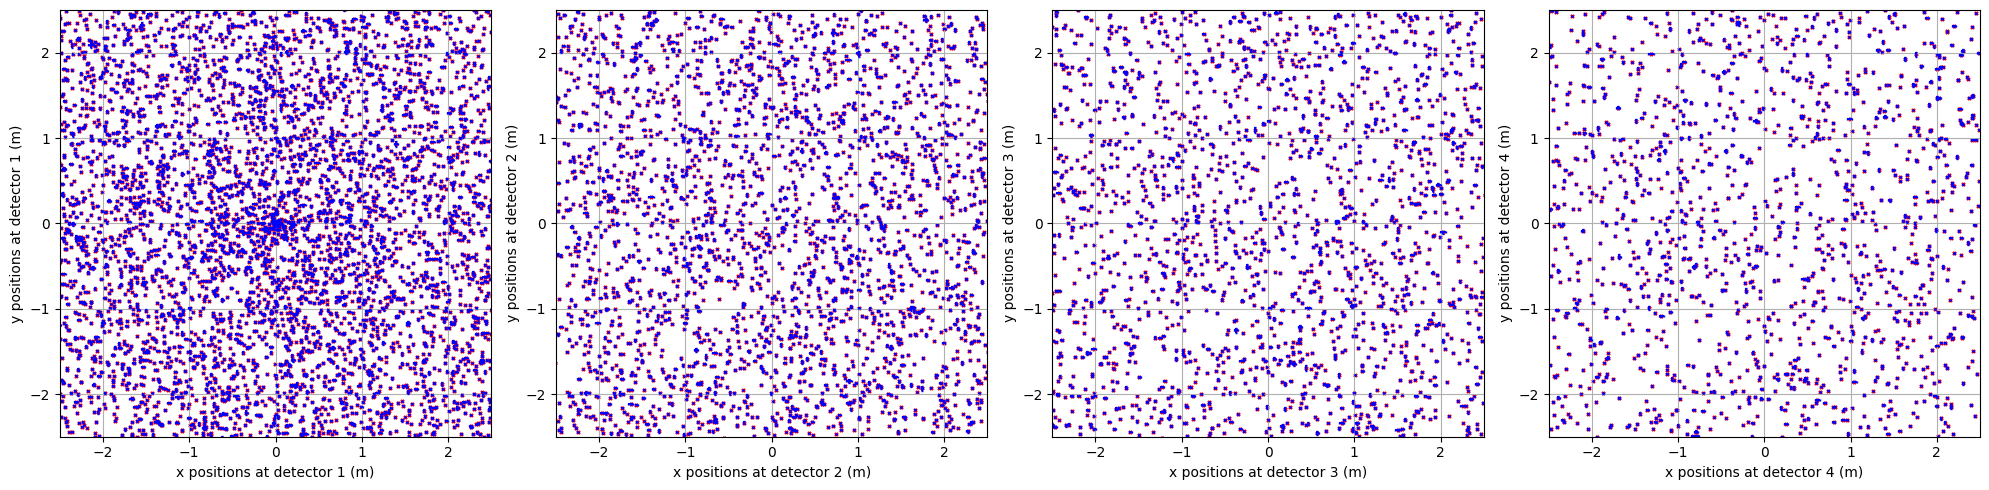

In [151]:
run, num_hits = simulation(N, mean_v, std_v, Lambda, detector_positions)    

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax_i in enumerate(axes):
    xcol = f'x{i+1}'
    ycol = f'y{i+1}'
    mask = (run[xcol] != 0) | (run[ycol] != 0)  # plot only non-zero hits
    ax_i.scatter(run.loc[mask, xcol], run.loc[mask, ycol], s=5, color='red', marker="x")
    ax_i.errorbar(run.loc[mask, xcol], run.loc[mask, ycol], xerr=run.loc[mask, f'{xcol}_err'], yerr=run.loc[mask, f'{ycol}_err'], fmt='none', ecolor='blue', capsize=1)
    ax_i.set_xlabel(f'x positions at detector {i+1} (m)')
    ax_i.set_ylabel(f'y positions at detector {i+1} (m)')
    ax_i.set_xlim(-2.5, 2.5)
    ax_i.set_ylim(-2.5, 2.5)
    ax_i.grid(True)

plt.tight_layout()
plt.show()


The cell above displays the distributions of the particles registered at each tracking station. As we would expect the first tracking station records the largest number of hits and the number detected by each further station decreases every time. Furthermore, there is an intial concentration around the origin of stn. 1, this is due to the fact that some particles will decay very close to the detector and distribution of hits should be skewed towards this point and decrease outwards. 

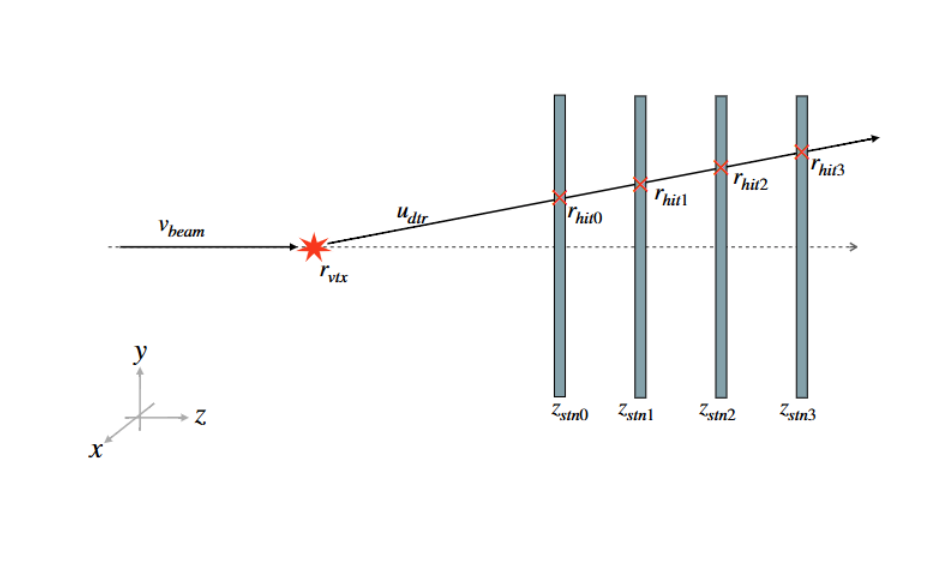



This is a copy of the diagram from the assignment brief. To validate the data from the simulation above, the expected values have been calculated.

Using the base parameters given in the brief and a few others:
* $N = 10^6$ particles
* $\tau = 2.5ms$
* $\mu_v = 2000ms^{-1}$
* $z_{stn} = 30, 35, 40, 45m$
* stn size: $\Delta x = 2a = 5m, \Delta y = 2b = 5m$
* $\sigma_{x, y} = 0.01m$

Therefore, the mean $z$ value of the decay position of the particle, $r_{vtx}$, is 5m which gives a simplistic estimate of the number of particles hitting the first tracking station to be:

$$ N_{1} = N  \frac{\Omega}{4\pi}$$

Here $\Omega$ is the solid angle of the first square detector, given by:

$$ \Omega = 4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)$$

Where $R$ is the distance of the detector from the mean value of $r_{vtx}$. 

However, in reality the number of particles which collide with the first tracking station is much greater as some particles decay closer to the detector than this mean distance of 25 meters and the solid angle increases as $r_{vtx}$ increases. The probability distribution function given above can be multiplied by the equation for the solid angle fraction and the total number of particles, $N$, to give the number of particles expected to decay at a value of $z$ and still collide with the first racking station, $A(z)$. Integrating over $z$ will then display the total number of particles incident on the first tracking station, $N_{1}$:

$$ A(z) = N \left(\frac{\lambda}{\sqrt{2 \pi \sigma}} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db \right ) \left( \frac{4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)}{4 \pi} \right)$$

for $N = 10^6$:

$$ N_{1} = \int_0^{30} A(z) dz = 4505 $$

As all particles are assumed to travel linearly, no particles which miss detector one can hit any of the later detectors. 




In [152]:
num_hits_total = (run['x1'] != 0).sum()

Markdown(f"Total number to hit any detectors: {num_hits_total}")

Total number to hit any detectors: 4571

(array([1976.,  764.,  475., 1356.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5]),
 <BarContainer object of 4 artists>)

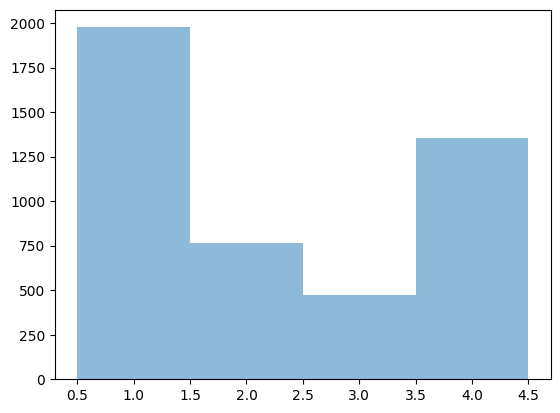

In [ ]:
num_hits_list = num_hits.tolist()
plt.hist(num_hits_list, bins=np.arange(min(num_hits_list)+1, max(num_hits_list) + 2.0) - 0.5, alpha=0.5)


This histogram display of the number of hits by each particle which is leaning heavily towards one. As 

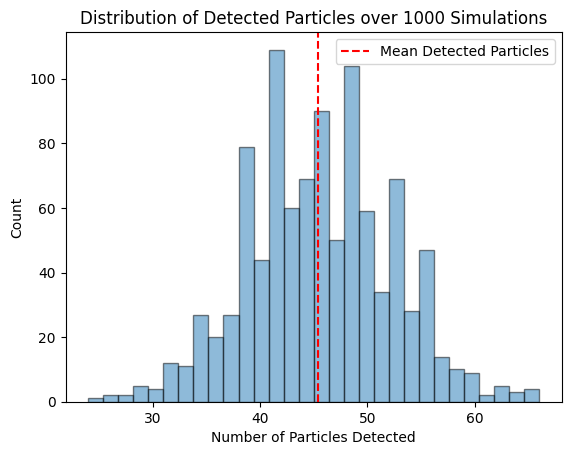

45.439


In [139]:
num_tests = 1000
num_particles = 10000
mean_v = 2000
std_v = 100
Lambda = 0.0025
detector_positions = [30, 35, 40, 45]

num_hits_run = []


for test in range(num_tests):

    run, num_hits_list = simulation(num_particles, mean_v, std_v, Lambda, detector_positions)
    particles_with_hits = (run['x1'] != 0).sum()
    num_hits_run.append(particles_with_hits)

plt.hist(num_hits_run, bins=30, alpha=0.5, edgecolor='black')
plt.xlabel('Number of Particles Detected')
plt.ylabel('Count')
plt.title('Distribution of Detected Particles over 1000 Simulations')
plt.axvline(x=np.mean(num_hits_run), color='r', linestyle='--', label='Mean Detected Particles')
plt.legend()
plt.show()


print(np.mean(num_hits_run))